# Improved feature engineering
*Anders Poirel - 11-02-2020*


Ideas I'll be building on
- seperating by city (data has different structure between the cities, avoids needing to build a more complex model that captures feature interactions)
- using the lifecycle of the mosquito: new mostiquos become adults 1-3 weeks after eggs are laid in water. Therefore, we could expect a lot of cases if the previous 2-3week/~month was humid

**Note**: I realized I used *median* absolute error instead of mean absolute error in the previous notebook, which explain why my CV scores were so far from the test set scores!

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import sklearn
from os.path import join

In [3]:
DATA_PATH = '../data/raw/'

## Acquiring the data

In [98]:
X_test_o = pd.read_csv(join(DATA_PATH, 'dengue_features_test.csv'))
X_train_o = pd.read_csv(join(DATA_PATH, 'dengue_features_train.csv'))
y_train_o = pd.read_csv(join(DATA_PATH, 'dengue_labels_train.csv'))

### Preprocessing

In [5]:
X_train = pd.get_dummies(X_train_o, columns = ['city'], drop_first = True)
X_test = pd.get_dummies(X_test_o, columns = ['city'], drop_first = True)
X_train = X_train.drop('week_start_date', axis = 1)
X_test = X_test.drop('week_start_date', axis = 1)

Drop features that have correlation 1 with other features

In [6]:
X_train.drop(
    ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k',
     'reanalysis_tdtr_k'],
    axis = 1, 
    inplace = True
)

In [7]:
X_test.drop(
    ['reanalysis_sat_precip_amt_mm', 'reanalysis_dew_point_temp_k',
     'reanalysis_tdtr_k'],
    axis = 1, 
    inplace = True
)

In [44]:
y_train

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


### Precipitation at several time lags

First, we split the data by city:

In [48]:
X_train_sj = X_train[X_train['city_sj'] == 1]
X_train_iq = X_train[X_train['city_sj'] == 0]

X_test_sj = X_test[X_test['city_sj'] == 1]
X_test_iq = X_test[X_test['city_sj'] == 0]

y_train_sj = y_train[y_train['city'] == 'sj']['total_cases']
y_train_iq = y_train[y_train['city'] == 'iq']['total_cases']

In [49]:
def precip_n_weeks(k, n, precips):
    if k - n < 0:
        re turn .0
    else:
        return precips[k - n]    

In [50]:
train_precip_sj = X_train_sj['precipitation_amt_mm']
train_precip_iq = X_train_iq['precipitation_amt_mm']

test_precip_sj = X_test_sj['precipitation_amt_mm']
test_precip_iq = X_test_iq['precipitation_amt_mm']

We re-index the series for Iquitos so that they start from 0 and our code can run properly

In [51]:
iq_train_index = list(range(len(train_precip_iq)))
iq_test_index = list(range(len(test_precip_iq)))
train_precip_iq.index = iq_train_index
test_precip_iq.index = iq_test_index

In [53]:
X_train_sj['precip_2'] = [precip_n_weeks(k, 2, train_precip_sj)
                          for k in range(len(train_precip_sj))]
X_train_sj['precip_3'] = [precip_n_weeks(k, 3, train_precip_sj) 
                          for k in range(len(train_precip_sj))]
X_train_sj['precip_4'] = [precip_n_weeks(k, 4, train_precip_sj)
                          for k in range(len(train_precip_sj))]

X_test_sj['precip_2'] = [precip_n_weeks(k, 2, test_precip_sj)
                          for k in range(len(test_precip_sj))]
X_test_sj['precip_3'] = [precip_n_weeks(k, 3, test_precip_sj) 
                          for k in range(len(test_precip_sj))]
X_test_sj['precip_4'] = [precip_n_weeks(k, 4, test_precip_sj)
                          for k in range(len(test_precip_sj))]

X_train_iq['precip_2'] = [precip_n_weeks(k, 2, train_precip_iq)
                          for k in range(len(train_precip_iq))]
X_train_iq['precip_3'] = [precip_n_weeks(k, 3, train_precip_iq) 
                          for k in range(len(train_precip_iq))]
X_train_iq['precip_4'] = [precip_n_weeks(k, 4, train_precip_iq)
                          for k in range(len(train_precip_iq))]

X_test_iq['precip_2'] = [precip_n_weeks(k, 2, test_precip_iq)
                          for k in range(len(test_precip_iq))]
X_test_iq['precip_3'] = [precip_n_weeks(k, 3, test_precip_iq) 
                          for k in range(len(test_precip_iq))]
X_test_iq['precip_4'] = [precip_n_weeks(k, 4, test_precip_iq)
                          for k in range(len(test_precip_iq))]

C:\Users\Anders\Miniconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\Users\Anders\Miniconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\Users\Anders\Miniconda3\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the d

Let's check that this worked as intended:

In [54]:
X_test_sj.head(30)

,year,weekofyear,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,reanalysis_avg_temp_k,reanalysis_max_air_temp_k,...,reanalysis_specific_humidity_g_per_kg,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm,city_sj,precip_2,precip_3,precip_4
0,2008,18,-0.018900,-0.018900,0.102729,0.091200,78.60,298.492857,298.550000,301.1,...,15.918571,26.528571,7.057143,33.3,21.7,75.2,1,0.00,0.00,0.00
1,2008,19,-0.018000,-0.012400,0.082043,0.072314,12.56,298.475714,298.557143,300.8,...,15.791429,26.071429,5.557143,30.0,22.2,34.3,1,0.00,0.00,0.00
2,2008,20,-0.001500,NaN,0.151083,0.091529,3.66,299.455714,299.357143,302.2,...,16.674286,27.928571,7.785714,32.8,22.8,3.0,1,78.60,0.00,0.00
3,2008,21,NaN,-0.019867,0.124329,0.125686,0.00,299.690000,299.728571,303.0,...,15.775714,28.057143,6.271429,33.3,24.4,0.3,1,12.56,78.60,0.00
4,2008,22,0.056800,0.039833,0.062267,0.075914,0.76,299.780000,299.671429,302.3,...,16.137143,27.614286,7.085714,33.3,23.3,84.1,1,3.66,12.56,78.60
5,2008,23,-0.044000,-0.030467,0.132000,0.083529,71.17,299.768571,299.728571,301.9,...,16.667143,28.000000,5.171429,32.8,25.0,27.7,1,0.00,3.66,12.56
6,2008,24,-0.044300,-0.024925,0.132271,0.159157,48.99,300.062857,300.007143,302.4,...,17.010000,27.400000,6.042857,31.1,23.3,91.7,1,0.76,0.00,3.66
7,2008,25,NaN,0.082150,0.144371,0.116729,30.81,300.484286,300.578571,303.5,...,17.420000,28.757143,6.985714,34.4,24.4,0.3,1,71.17,0.76,0.00
8,2008,26,0.010800,0.049900,0.100571,0.117329,8.02,300.601429,300.621429,302.5,...,17.678571,28.657143,6.242857,32.8,23.9,28.7,1,48.99,71.17,0.76
9,2008,27,0.072667,0.106660,0.155429,0.164900,17.52,300.497143,300.528571,302.3,...,17.808571,28.457143,4.628571,31.1,25.0,2.9,1,30.81,48.99,71.17


## Building the models

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import (cross_validate, TimeSeriesSplit, 
                                     RandomizedSearchCV)

#### ElasticNet with penalty

San Jose:

In [118]:
en_sj = Pipeline([
    ('scale', StandardScaler()),
    ('impute_m', SimpleImputer()),
    ('en', LinearRegression())
])
cv_res_sj = cross_validate(
    estimator = en_sj,
    X = X_train_sj,
    y = y_train_sj,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
en_sj_score = np.mean(cv_res_sj['test_score'])
en_sj_score

-47.21266448565494

In [119]:
en_sj.fit(X_train_sj, y_train_sj)

Pipeline(memory=None,
         steps=[('scale',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('impute_m',
                 SimpleImputer(add_indicator=False, copy=True, fill_value=None,
                               missing_values=nan, strategy='mean',
                               verbose=0)),
                ('en',
                 LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
                                  normalize=False))],
         verbose=False)

In [120]:
y_pred_sj = en_sj.predict(X_train_sj)

Iquitos:

In [87]:
en_iq = Pipeline([
    ('scale', StandardScaler()),
    ('impute_m', SimpleImputer()),
    ('en', ElasticNet(alpha = 10))
])
cv_res_iq = cross_validate(
    estimator = en_iq,
    X = X_train_iq,
    y = y_train_iq,
    cv = TimeSeriesSplit(n_splits = 10),
    scoring = 'neg_mean_absolute_error',
    n_jobs = -1
)
en_iq_score = np.mean(cv_res_iq['test_score'])
en_iq_score

-6.39528845973803

In [83]:
y_train_iq.mean()

7.565384615384615

Something is really strange here... both models have large MAEs (close to the means values of the targets for each)

In [109]:
plt.style.use('default')

We get the date data for each city:

In [121]:
sj_dates = X_train_o[X_train_o['city'] == 'sj']['week_start_date']
iq_dates = X_train_o[X_train_o['city'] == 'iq']['week_start_date']

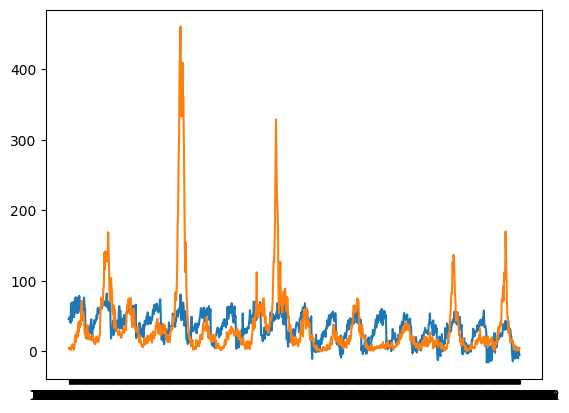

In [122]:
ax = plt.axes()
ax.plot(sj_dates, y_pred_sj)
ax.plot(sj_dates, y_train_sj)

It appears that the model is predicting very close to the mean

### Building a submission

In [ ]:
submission = pd.read_csv(join(DATA_PATH, 'submission_format.csv'))

In [ ]:
y_pred = poly_model_3.predict(X_test)
submission['total_cases'] = np.round(y_pred).astype(int)

In [ ]:
submission

In [ ]:
submission.to_csv('../models/baseline.csv', index = False)